# Top2Vec
#### A topic Modelling analyis of 6000 articles from the gov.uk pertaining to the environment.

In [262]:
from top2vec import Top2Vec
import numpy as np
from gensim.utils import simple_preprocess
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import matplotlib.pyplot as plt
import PyPDF2
import json
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

In [ ]:
np.random.seed(0)

# Load text data from output.txt
with open('articles.json','r') as f:
    data = json.load(f)

content = [articles['content'] for articles in data]

In [263]:
%%capture
# instantiate Top2Vec model with a document threshold of 0.6
model = Top2Vec(content, min_count=5, embedding_model='universal-sentence-encoder')

2023-05-13 16:52:31,334 - top2vec - INFO - Pre-processing documents for training
2023-05-13 16:52:47,870 - top2vec - INFO - Downloading universal-sentence-encoder model
2023-05-13 16:52:51,987 - top2vec - INFO - Creating joint document/word embedding
2023-05-13 16:53:13,651 - top2vec - INFO - Creating lower dimension embedding of documents
2023-05-13 16:53:23,796 - top2vec - INFO - Finding dense areas of documents
2023-05-13 16:53:23,927 - top2vec - INFO - Finding topics


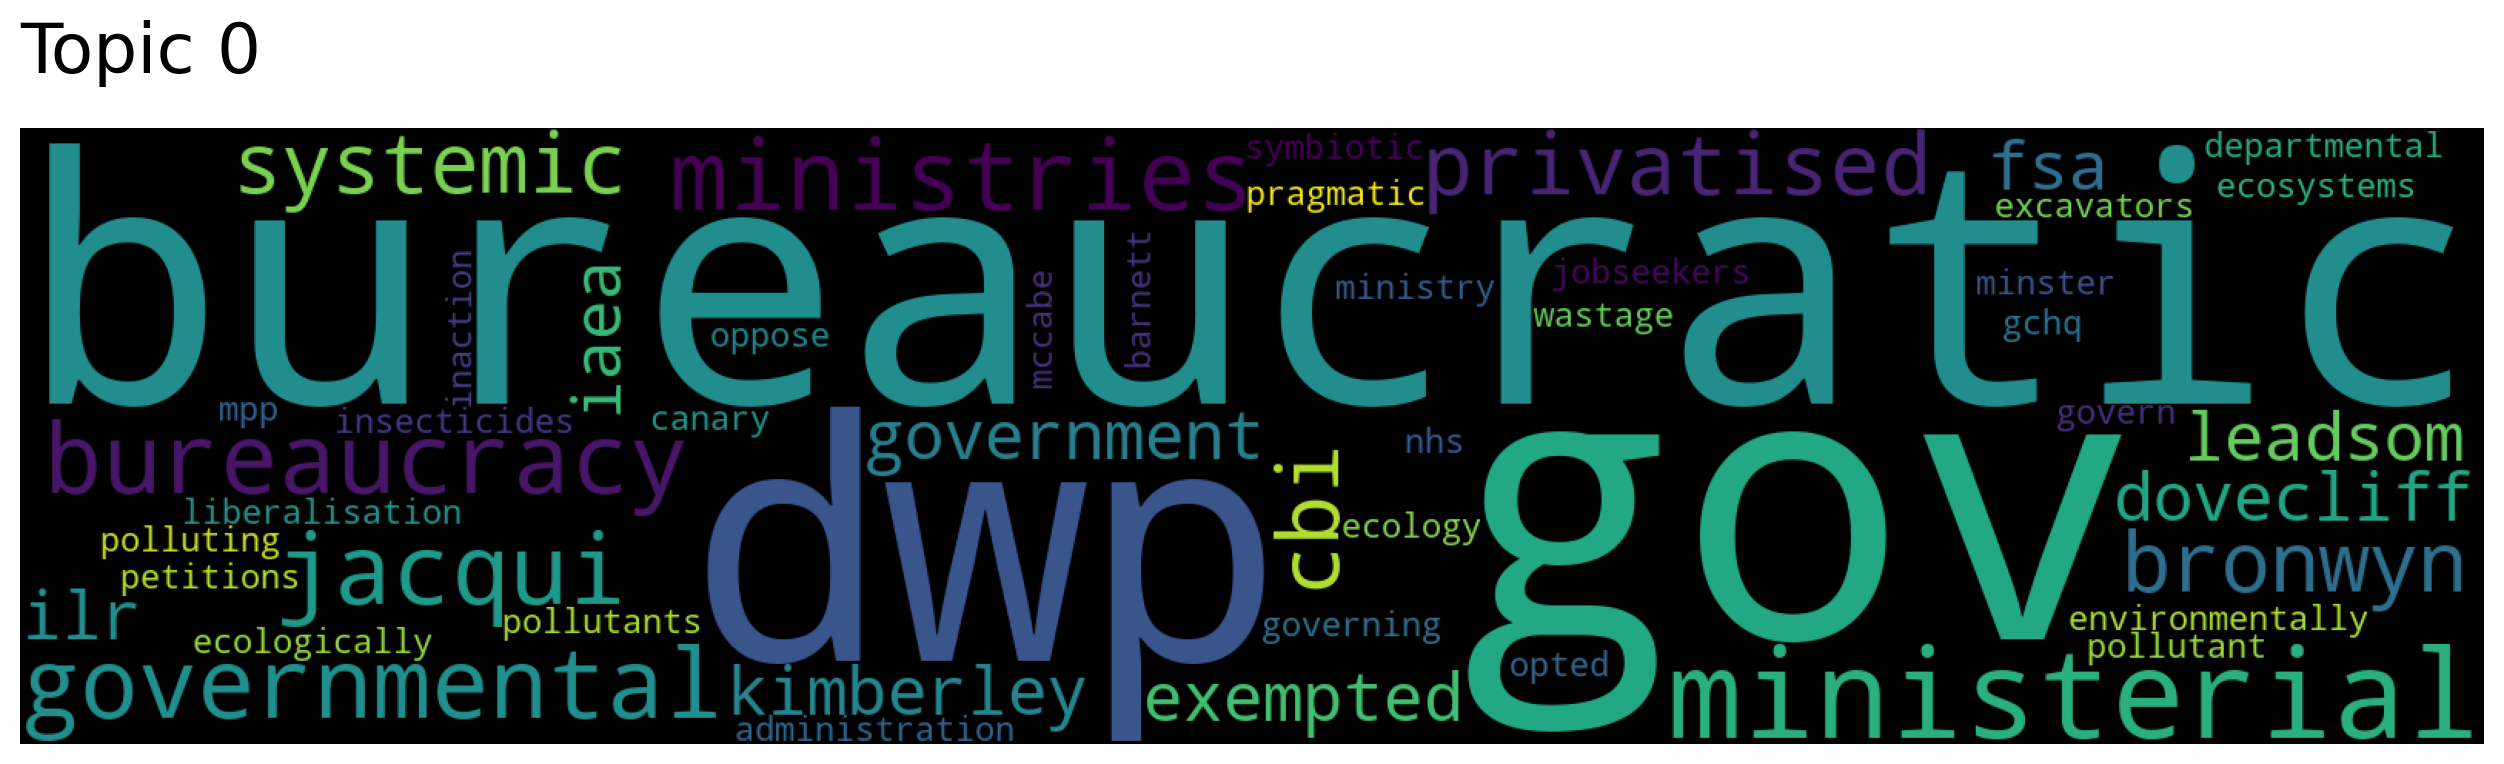

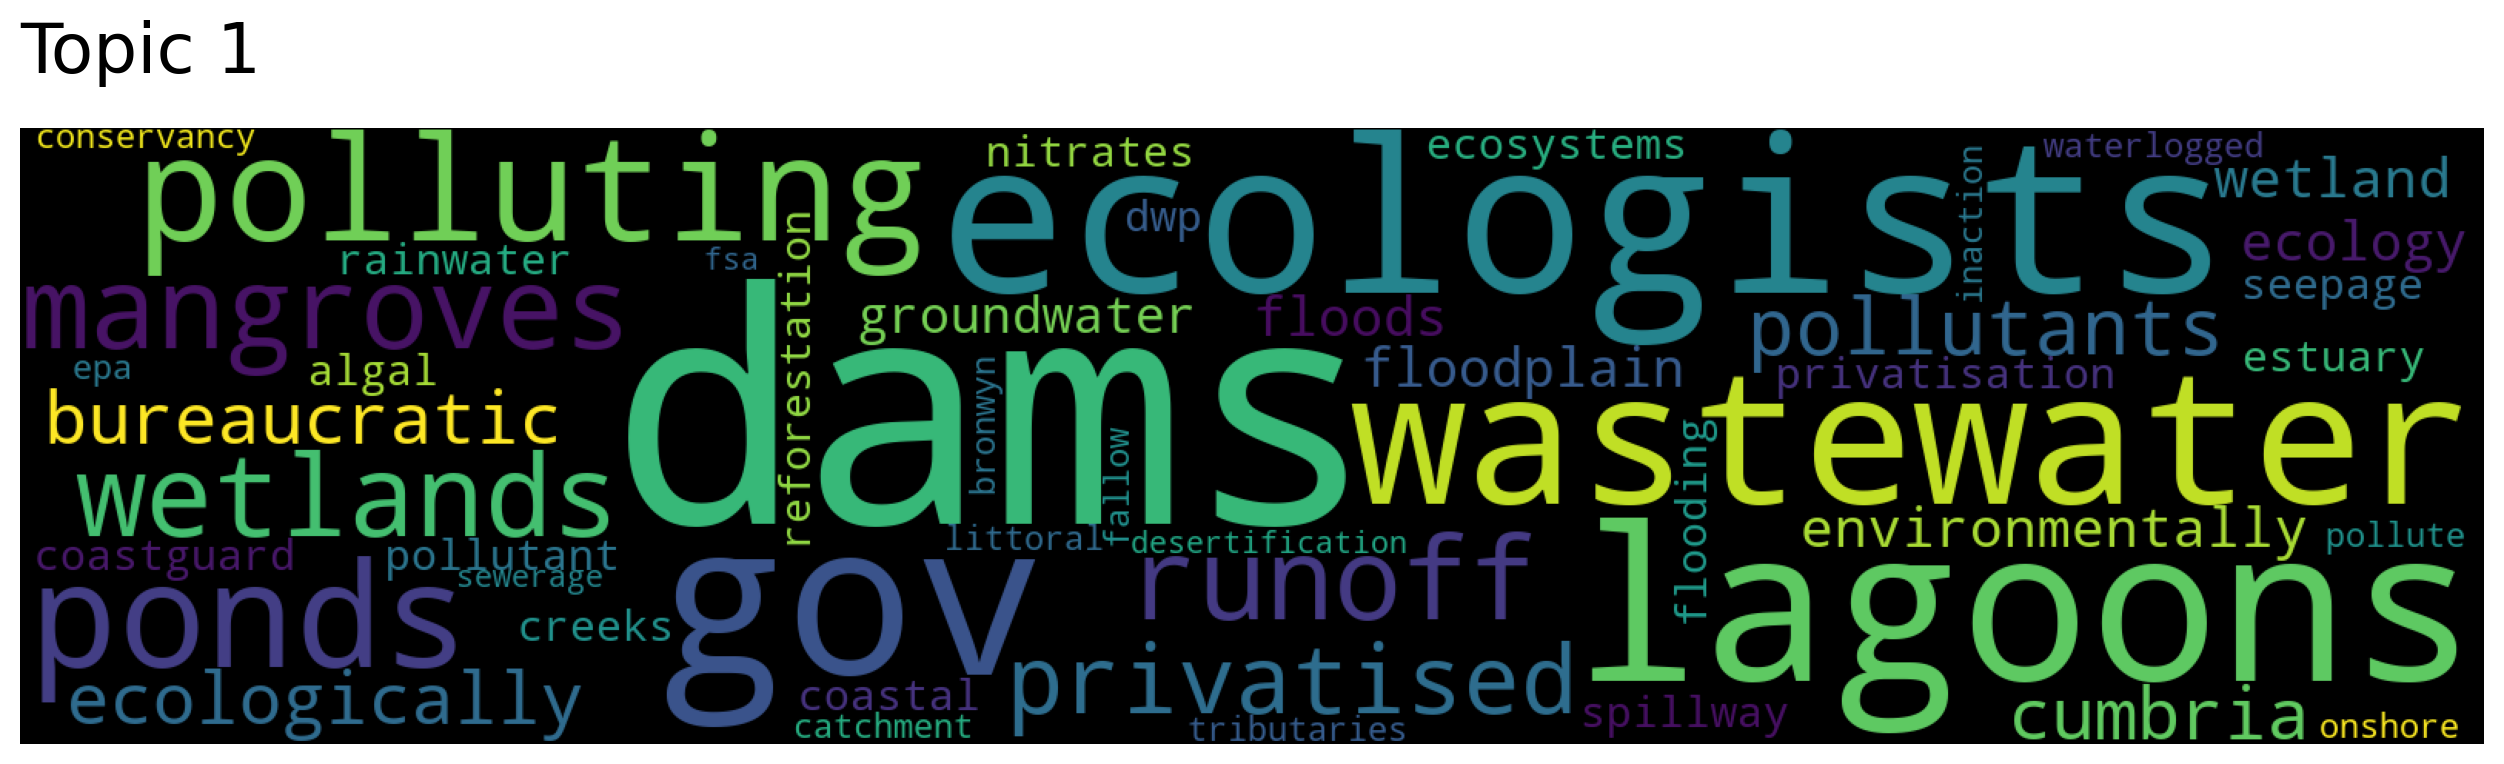

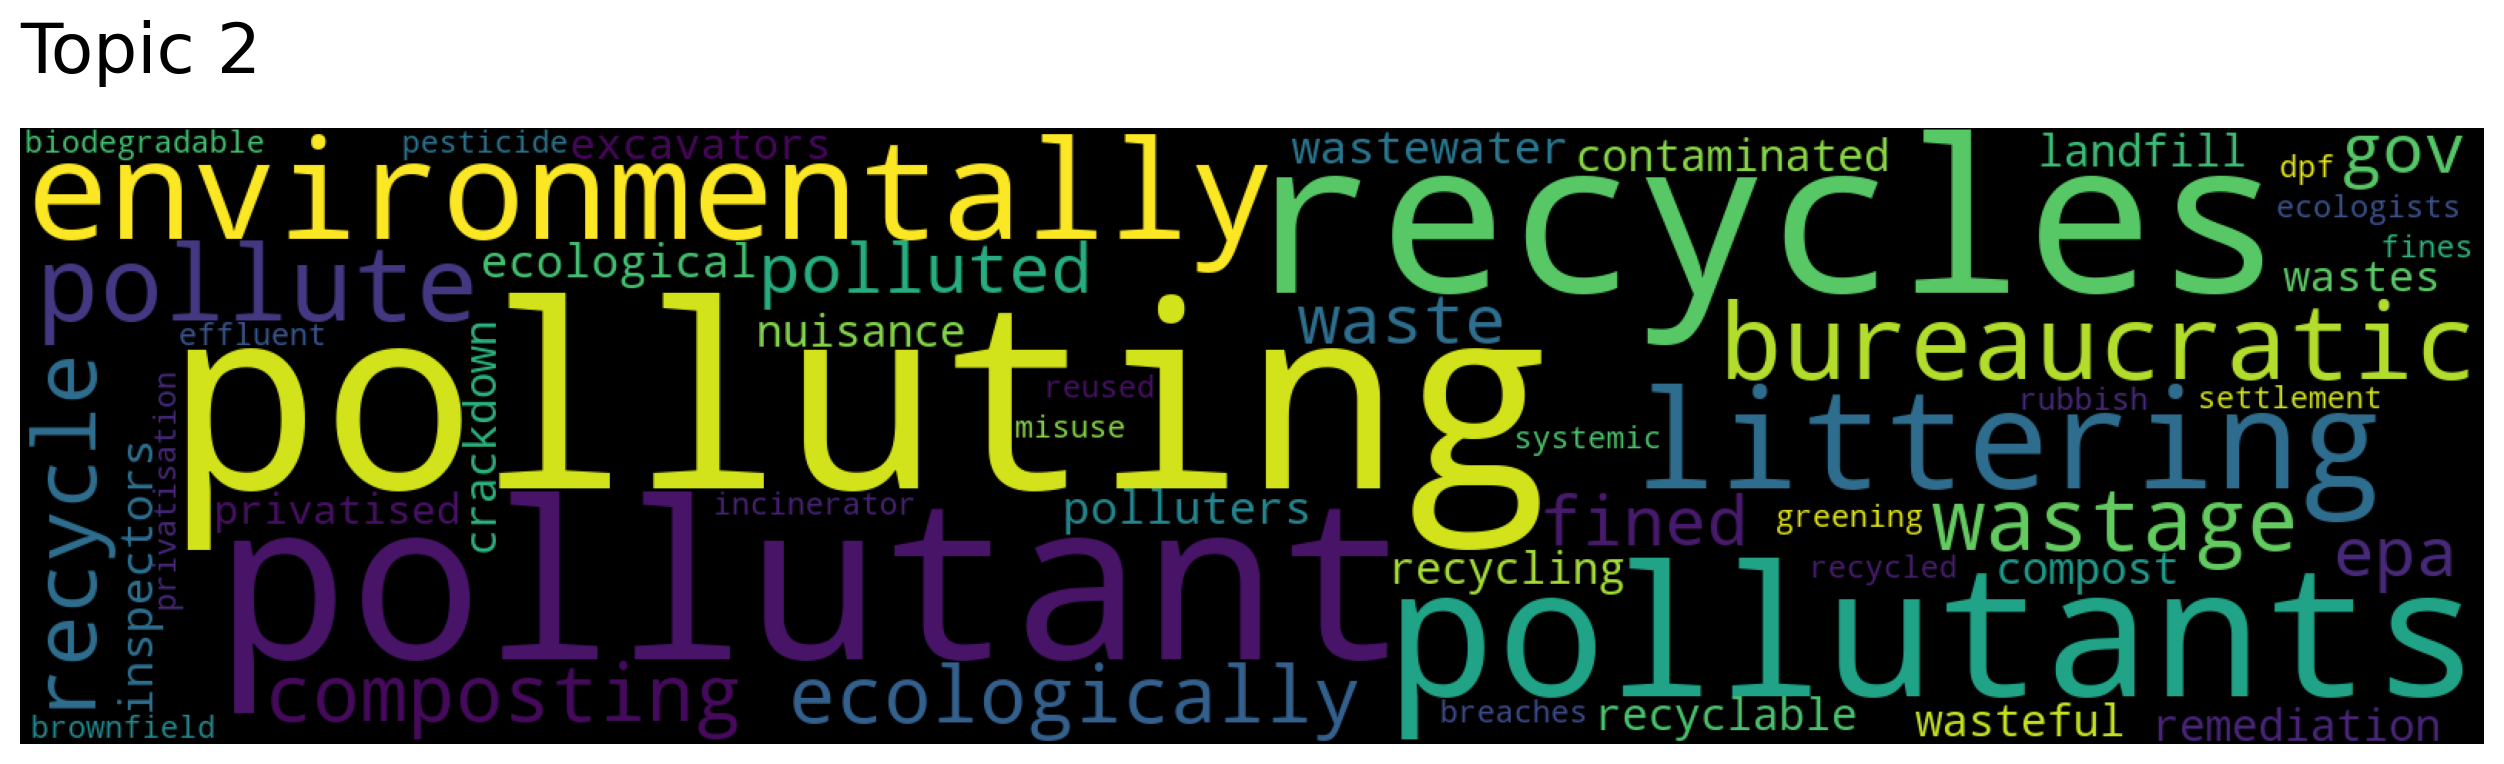

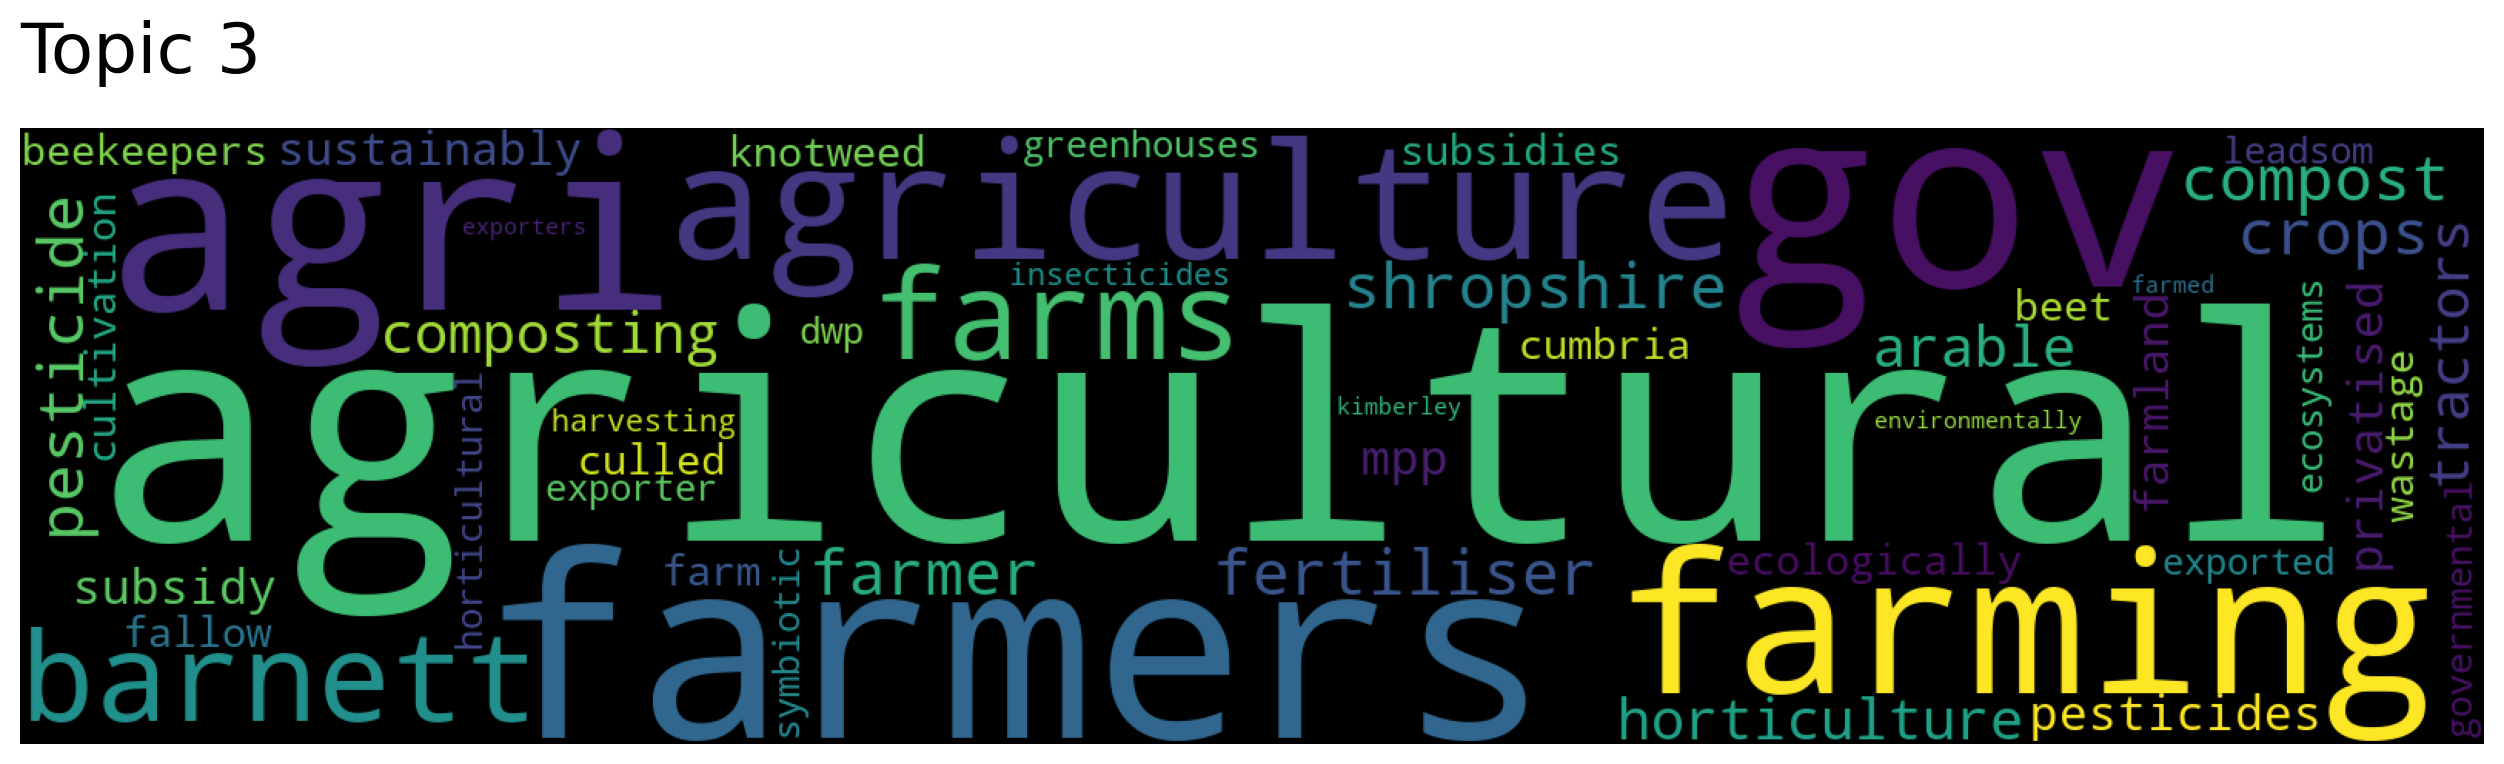

In [264]:
topic_words, word_scores, topic_nums = model.get_topics(model.get_num_topics())
for topic in topic_nums[:4]:
    model.generate_topic_wordcloud(topic)

# Search document by topic

In [293]:
# search for documents by topic
topic_num = 2
num_docs = 40
_, document_scores, document_ids = model.search_documents_by_topic(topic_num=topic_num, num_docs=num_docs)

# create a dataframe with the document titles and scores
document_list = []
for score, doc_id in zip(document_scores, document_ids):
    article = data[doc_id]
    title = article['title']
    URL = article['url']
    document_list.append({'Title': title.strip(), 'Score': score, 'URL' : URL})

# create a dataframe from the document list
dataframe = pd.DataFrame(document_list)

# print the dataframe
dataframe.head()

Title     Score   
0  Illegal activity costs Kings Lynn skip company...  0.948034  \
1  Environment Agency targets Canterbury waste sites  0.944285   
2      Environment Agency targets Merton waste sites  0.943637   
3        Environment Agency weeds out waste villains  0.942757   
4     Environment Agency targets Croydon waste sites  0.940528   

                                                 URL  
0  https://www.gov.uk/government/news/illegal-act...  
1  https://www.gov.uk/government/news/environment...  
2  https://www.gov.uk/government/news/environment...  
3  https://www.gov.uk/government/news/environment...  
4  https://www.gov.uk/government/news/environment...

# Similarity, EA 2021

In [315]:
# open the PDF file and extract the text
pdf_file = open('EA-2021.pdf', 'rb')
pdf_reader = PyPDF2.PdfReader(pdf_file)
environmental_act_text = ""
for page in pdf_reader.pages:
    environmental_act_text += page.extract_text()
    
# create a dictionary with the title and content of the Environmental Act
environmental_act = {
    'title': 'Environmental Act 2021',
    'content': environmental_act_text,
    'url' : 'https://www.legislation.gov.uk/ukpga/2021/30/contents/enacted'
}

# append the Environmental Act dictionary to the list of articles
data.append(environmental_act)

In [310]:
%%capture
# instantiate Top2Vec model with a document threshold of 0.6
model = Top2Vec(content, min_count=5, embedding_model='universal-sentence-encoder')

2023-05-13 17:51:12,586 - top2vec - INFO - Pre-processing documents for training
2023-05-13 17:51:29,429 - top2vec - INFO - Downloading universal-sentence-encoder model
2023-05-13 17:51:33,711 - top2vec - INFO - Creating joint document/word embedding
2023-05-13 17:51:55,181 - top2vec - INFO - Creating lower dimension embedding of documents
2023-05-13 17:52:07,058 - top2vec - INFO - Finding dense areas of documents
2023-05-13 17:52:07,187 - top2vec - INFO - Finding topics


In [311]:
# Load the Top2Vec model and the documents
documents = content

# Preprocess the documents
tokenized_docs = [simple_preprocess(doc) for doc in documents]

# Create tagged documents for Doc2Vec
tagged_docs = [TaggedDocument(doc, [i]) for i, doc in enumerate(tokenized_docs)]

# Train a Doc2Vec model on the documents
doc2vec_model = Doc2Vec(tagged_docs, vector_size=300, window=5, min_count=1, epochs=10)

# Get the embeddings for each document
embeddings = np.array([doc2vec_model.infer_vector(doc) for doc in tokenized_docs])

In [312]:
EA_2021_emb = embeddings[5804]

In [322]:
# Compute the cosine similarities between the embeddings
similarities = cosine_similarity(embeddings, EA_2021_emb.reshape(1, -1))

# Create a dataframe with the indices and similarities
df = pd.DataFrame({'index': np.arange(len(similarities)), 'similarity': similarities.flatten()})

# Sort the dataframe by similarity in descending order
df = df.sort_values(by='similarity', ascending=False)

def find_title(x):
    return data[x +1]['title'].strip()

def find_URL(x):
    return data[x +1]['url'].strip()

df['title'] = df.index.map(lambda x:find_title(x))
#df['URL'] = df.index.map(lambda x:find_URL(x))

# Similar documents

In [325]:
df.head()

index  similarity                                              title
5804   5804    1.000000                             Environmental Act 2021
2827   2827    0.666190  Greater Manchester heads way on sustainable fo...
4551   4551    0.657274  WTO Trade Policy Review of Barbados: UK statement
5596   5596    0.655979  Finance boost to help protect developing count...
5664   5664    0.647319   ‘Gentleman Jack’ - in need of the Coal Authority

# Disimilar documents

In [326]:
df.tail()

index  similarity                                              title
2459   2459   -0.113837  First Annual Congress of FAO Reference Centres...
5732   5732   -0.119409  UK AT HEART OF INTERNATIONAL MISSILE DEFENCE E...
3626   3626   -0.152359  Scrapyard permit dodger claims end-of-life veh...
4428   4428   -0.166178  Helping instructors with improved immersive tr...
4526   4526   -0.173021  UK signs fisheries agreement with the Faroe Is...

# Similarity distribution

<AxesSubplot:>

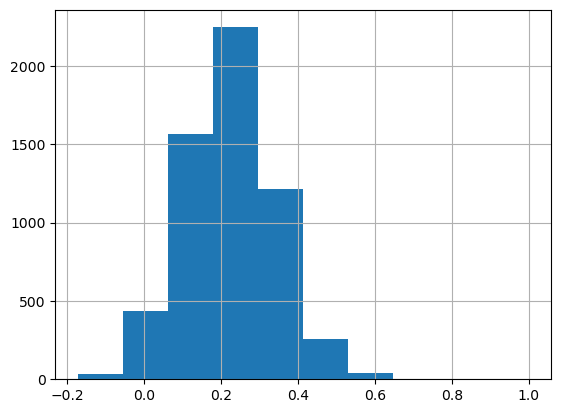

In [327]:
df.similarity.hist()